In [1]:
import pymongo
client = pymongo.MongoClient()
summoner_ranks = {}
for g in client.clash.rank.find():
    summoner_ranks[g["summonerId"]] = {"tier":g["tier"],"rank":g["rank"]}

In [2]:
table = client.clash.game_all
clash_summoners = []
for g in table.find({"platformId":"EUW1","queueId":700},{"participantIdentities":1}):
    for p in g["participantIdentities"]:
        clash_summoners.append(p["player"]["summonerId"])

In [3]:
import sortedcontainers
clash_summoners = sortedcontainers.SortedSet(clash_summoners)

In [4]:
rank_distribution = {}
participant_rank_distribution = {}
for i,v in summoner_ranks.items():
    full_rank = v["tier"]+"_"+v["rank"]
    if not full_rank in rank_distribution:
        rank_distribution[full_rank] = 0
        participant_rank_distribution[full_rank] = 0
    if i in clash_summoners:
        participant_rank_distribution[full_rank] += 1
    rank_distribution[full_rank] += 1

In [5]:
rank_distribution

{'BRONZE_IV': 75451,
 'BRONZE_II': 132529,
 'BRONZE_I': 202890,
 'BRONZE_III': 85806,
 'SILVER_II': 286827,
 'SILVER_IV': 292612,
 'SILVER_I': 247712,
 'SILVER_III': 231240,
 'GOLD_IV': 399780,
 'GOLD_I': 122165,
 'GOLD_III': 213980,
 'GOLD_II': 194163,
 'PLATINUM_IV': 211205,
 'PLATINUM_I': 62654,
 'PLATINUM_II': 56818,
 'PLATINUM_III': 81686,
 'IRON_I': 36445,
 'IRON_III': 12151,
 'IRON_II': 26085,
 'DIAMOND_IV': 56715,
 'DIAMOND_I': 5296,
 'DIAMOND_III': 20117,
 'DIAMOND_II': 10016,
 'IRON_IV': 2406,
 'MASTER_I': 1885,
 'GRANDMASTER_I': 714,
 'CHALLENGER_I': 306}

There are slight difference with what should be due to the time needed to gather all ranks (306 challengers instead of 300).

In [6]:
participant_rank_distribution

{'BRONZE_IV': 2055,
 'BRONZE_II': 4824,
 'BRONZE_I': 7997,
 'BRONZE_III': 2775,
 'SILVER_II': 16001,
 'SILVER_IV': 14064,
 'SILVER_I': 14050,
 'SILVER_III': 12178,
 'GOLD_IV': 34345,
 'GOLD_I': 11784,
 'GOLD_III': 21138,
 'GOLD_II': 18218,
 'PLATINUM_IV': 29153,
 'PLATINUM_I': 5354,
 'PLATINUM_II': 7988,
 'PLATINUM_III': 11912,
 'IRON_I': 738,
 'IRON_III': 118,
 'IRON_II': 358,
 'DIAMOND_IV': 12972,
 'DIAMOND_I': 1179,
 'DIAMOND_III': 4773,
 'DIAMOND_II': 2427,
 'IRON_IV': 16,
 'MASTER_I': 484,
 'GRANDMASTER_I': 177,
 'CHALLENGER_I': 50}

In [7]:
import pandas as pd
rankList = ["CHALLENGER_I","GRANDMASTER_I","MASTER_I"]
for t in ["DIAMOND","PLATINUM","GOLD","SILVER","BRONZE","IRON"]:
    for r in ["I","II","III","IV"]:
        rankList.append(t+"_"+r)
rankCat = pd.CategoricalDtype(rankList, ordered=True)

In [8]:
list_distribution = []
for i in rankCat.categories:
    list_distribution.append({"rank":i,"total":rank_distribution[i],"played":participant_rank_distribution[i]})
df_distribution = pd.DataFrame(list_distribution)

In [9]:
df_distribution["rank"] = df_distribution["rank"].astype(rankCat)
df_distribution.set_index(df_distribution["rank"], inplace=True)
del(df_distribution.index.name)
df_distribution["% played"] = df_distribution["played"] / df_distribution["total"]
df_distribution

,rank,total,played,% played
CHALLENGER_I,CHALLENGER_I,306,50,0.163399
GRANDMASTER_I,GRANDMASTER_I,714,177,0.247899
MASTER_I,MASTER_I,1885,484,0.256764
DIAMOND_I,DIAMOND_I,5296,1179,0.222621
DIAMOND_II,DIAMOND_II,10016,2427,0.242312
DIAMOND_III,DIAMOND_III,20117,4773,0.237262
DIAMOND_IV,DIAMOND_IV,56715,12972,0.228723
PLATINUM_I,PLATINUM_I,62654,5354,0.085453
PLATINUM_II,PLATINUM_II,56818,7988,0.140589
PLATINUM_III,PLATINUM_III,81686,11912,0.145827


In [10]:
df_distribution["total_without_played"] = df_distribution["total"] - df_distribution["played"]

Clash players comparison to the whole rank distribution

In [11]:
plt = df_distribution.sort_values("rank", ascending=False)[["played","total_without_played"]].plot(kind='barh', stacked=True,color=[["red"],["blue"]], figsize=(12,12), grid=True)
plt.legend(["Clash players", "Total ranked players"])
plt.set_title("Comparison between Clash players and ranked players by rank")

ylocs = plt.get_yticks()
l_played = list(df_distribution["total"].values)
l_played.reverse()
l_rank = list((df_distribution["% played"]*100).map('{:,.2f}%'.format).values)
l_rank.reverse()
for i, v in enumerate(l_rank):
    plt.text(l_played[i]+4000, ylocs[i] - 0.15, v)

Rank distribution for Clash players only

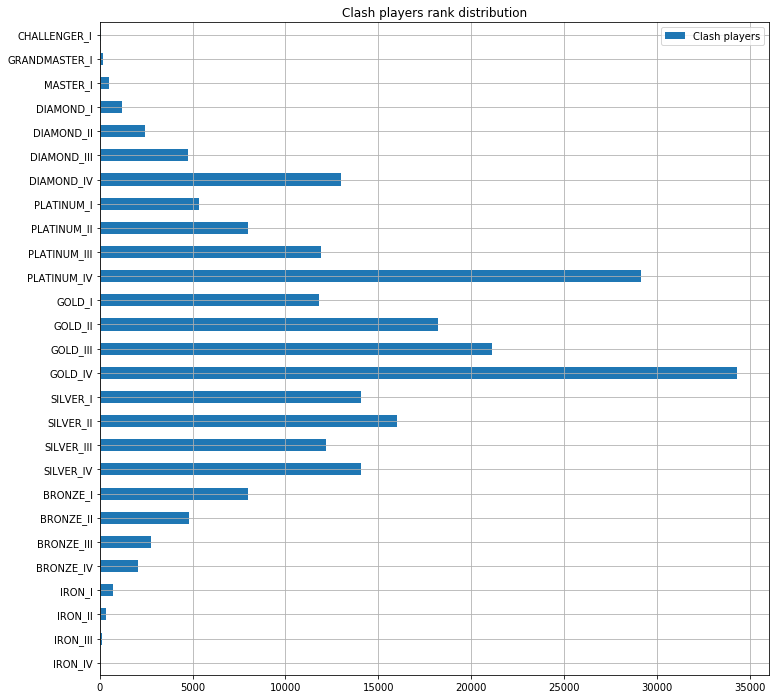

In [12]:
plt = df_distribution.sort_values("rank", ascending=False)[["played"]].plot(kind='barh', figsize=(12,12), grid=True)
plt.set_title("Clash players rank distribution")
plt.legend(["Clash players"])

Analysis of groups team rank cohesion

In [13]:
match_list = []
for g in table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"participantIdentities":1,"participants":1,"gameCreation":1}):
    row = {"gameId":g["gameId"]}
    row["timestamp"] = g["gameCreation"]
    pId_win = {p["participantId"]:p["stats"]["win"] for p in g["participants"]}
    for p in g["participantIdentities"]:
        row["summId"] = p["player"]["summonerId"]
        row["teamId"] = 100 if p["participantId"] <=5 else 200
        row["win"] = pId_win[p["participantId"]]
        match_list.append(dict(row))

In [14]:
len(match_list)

857330

In [15]:
df_match_list = pd.DataFrame(match_list)

In [16]:
df_matches_saturday = df_match_list[df_match_list["timestamp"] < 1570367865000]
df_matches_sunday = df_match_list[df_match_list["timestamp"] > 1570367865000]

Create a graph connceting players to matches. Each isolated subgraph should match a bracket.

In [17]:
import networkx as nx

In [18]:
G_saturday = nx.Graph() 
G_saturday.add_edges_from([(i["gameId"],i["summId"]) for k,i in df_matches_saturday.iterrows()]) 

In [19]:
G_sunday = nx.Graph() 
G_sunday.add_edges_from([(i["gameId"],i["summId"]) for k,i in df_matches_sunday.iterrows()]) 

Content of a normal bracket, 10 games and 40 players

In [20]:
nx.descendants(G_saturday, 4217595248)

{'0dyvu87XfUkzdK5iS9iknEiEJuA3VPvtFGL5usmD1XfvDDM',
 '0wMBJf1XflEjKtNVxfWxMWN-VYXVYE2rIESRIvW3h0quA7g',
 '1MNcKqUiAdxbmuC3TjlZgwY4V4jH71wjBdORr9fKUAs1sK4',
 '1ad8H8RglznrscJKqxS3kQzegov0BnJMCMynsNJtVousAaY',
 '1b3lZ4DPyPZJUb8GKMM13CISF0Qs-9XeOVY6I1YJusfagxk',
 '1vTEucwofztMEp-2ioQgIA2M4vwWUUwzZQCHXcCBeJ7kGl8',
 '2IfkdiXr3t2LZVLE8YiRI3EzWGRZfK9HM0EcCnx5nZ8o4vU',
 '2er32VC4B3nd4QKzswXDNxUPUFIj36xSwX0v5D6Js9BGwLY',
 4217490402,
 4217499822,
 4217532204,
 4217560553,
 4217595249,
 4217614108,
 4217643230,
 4217681592,
 4217721228,
 '5-B5pQ30rJ6USRvP3Jrs3UVYwS41TJx8XWDp1bNc8NBlhs4',
 '5WDx7XGIpykHagtvsOiG_gyzPDGf0lTbctxugBaxG1KyfAI',
 'B1h3QYQ_jLHLS8rnYVRElEjBApuwHRUKcX9uKOncRGHbTEs',
 'BDNxRvGkAHx-dcwqLObXdE50yiieNSStOKklX6gPMlspIB_-',
 'CAneSF2KOlx0qHmBvEzfWlKJucA5UIZiHWjM6mfoUPS3ZbPm',
 'CZz8ot3R8Sbw6UcmgFL6D8KgEg9Lswzq-XGPFweNfrrAPfmX',
 'Dn6wLUGsPD_KC4rvZLBNLEdUKOg3_yHHTXiFvnr2kqnhOUI',
 'EBN6gx9187QOvcINICXC5UxEp7ESXegWREprU476w7CeUN8',
 'EZZRRsvSKplZnRCbP5TJSi_Ews4ZAx944Pu5rXvajdAKFB

Grouping matches by brackets

In [21]:
groups_of_matches = []
matchlist_saturday = list(df_matches_saturday["gameId"].unique())
while len(matchlist_saturday) > 0:
    m = matchlist_saturday[0]
    group = [i for i in nx.descendants(G_saturday, m) if type(i) == int]
    group.append(m)
    groups_of_matches.append(list(group))
    for j in group:
        matchlist_saturday.remove(j)

Listing number of games by group

In [22]:
list_len = [len(i) for i in groups_of_matches]
{x:list_len.count(x) for x in list_len}

{10: 2679,
 9: 980,
 7: 159,
 8: 397,
 6: 81,
 5: 21,
 4: 13,
 26: 4,
 2: 4,
 1: 35,
 28: 1,
 17: 1,
 3: 3}

Some groups have strange number of games. Most of the time it's caused by broken brackets and forfeit.

In [23]:
for group in groups_of_matches:
    if len(group) == 28:
        print(group)
        break

[4217538572, 4217520156, 4217567781, 4217586246, 4217577542, 4217509961, 4217674354, 4217446532, 4217646732, 4217625301, 4217513182, 4217369322, 4217359638, 4217359637, 4217499437, 4217397582, 4217474896, 4217581919, 4217522068, 4217644949, 4217522590, 4217557924, 4217531826, 4217549236, 4217503701, 4217480185, 4217465853, 4217503702]


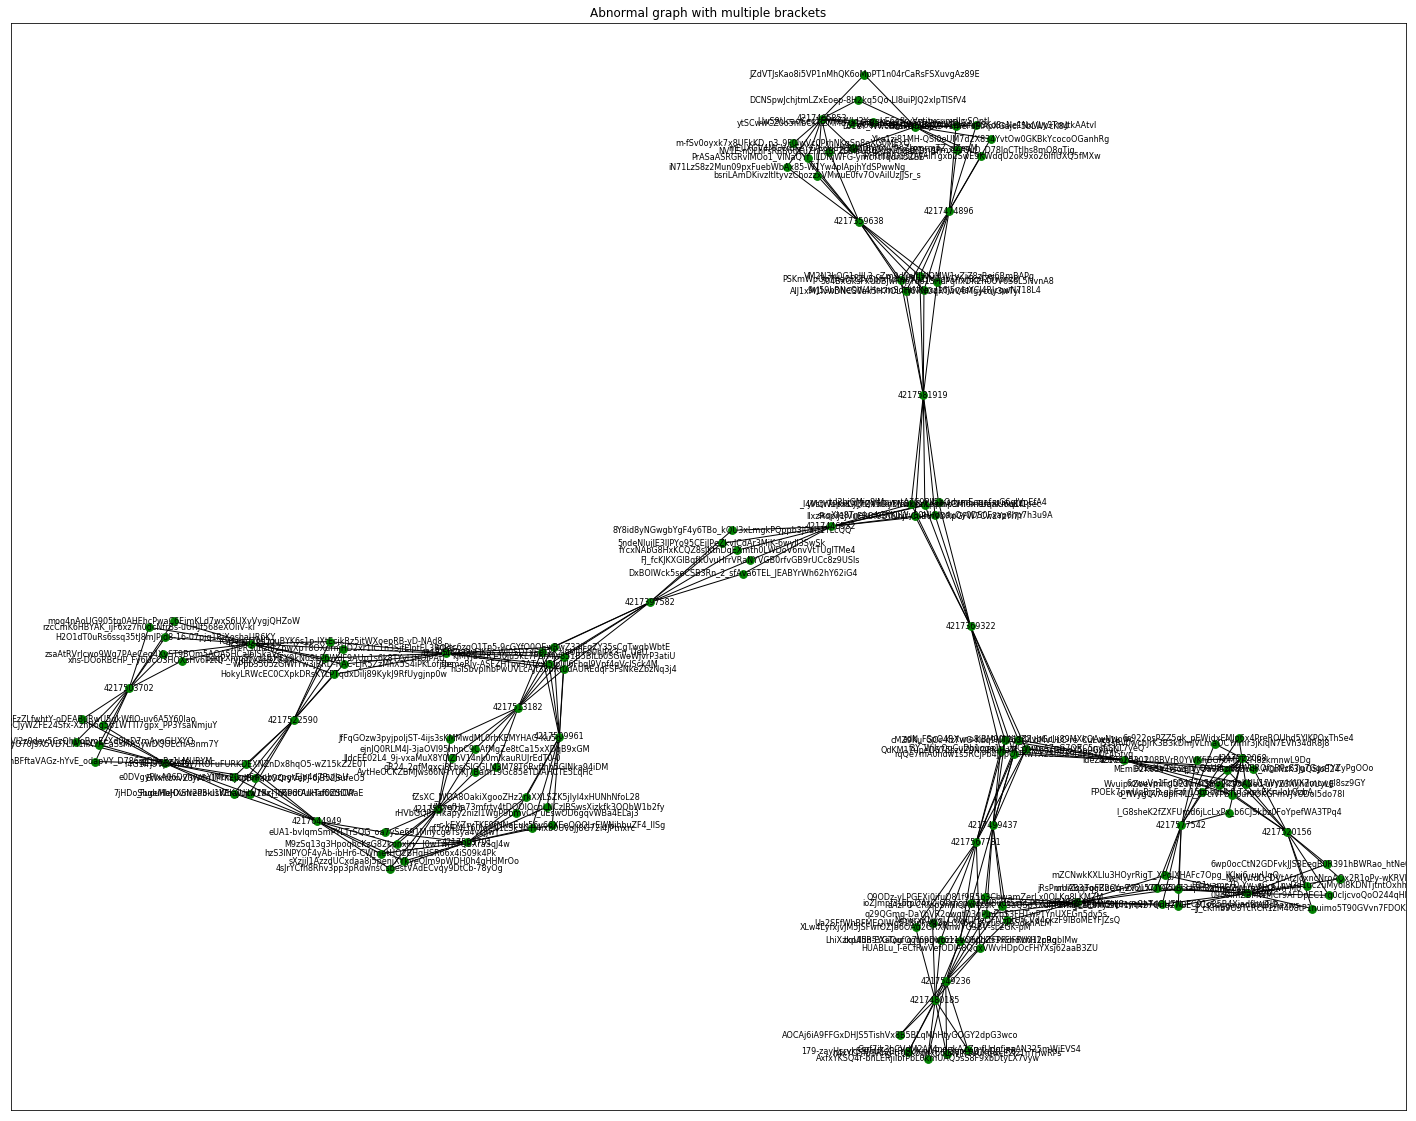

In [24]:
H = nx.Graph() 
H.add_edges_from([(i["gameId"],i["summId"]) for k,i in df_matches_saturday[df_matches_saturday["gameId"].isin(group)].iterrows()]) 

import matplotlib.pyplot as plt
plt.figure(3,figsize=(25,20)) 
nx.draw_networkx(H, with_labels = True, node_color ='green', node_size=60,font_size=8) 
plt.title("Abnormal graph with multiple brackets")
plt.show()

This show graph of a group, linking games and players. Numbers are games, the long strings of characters are players. Some teams played more than 3 games in one day, best guess is their bracket was canceled after the first game, and they have been relocated in another bracket, which leads to some abnormal graph like this.

For comparison, here is a normal bracket graph.

In [25]:
for group in groups_of_matches:
    if len(group) == 10:
        print(group)
        break

[4217721228, 4217614108, 4217532204, 4217499822, 4217681592, 4217643230, 4217490402, 4217560553, 4217595249, 4217595248]


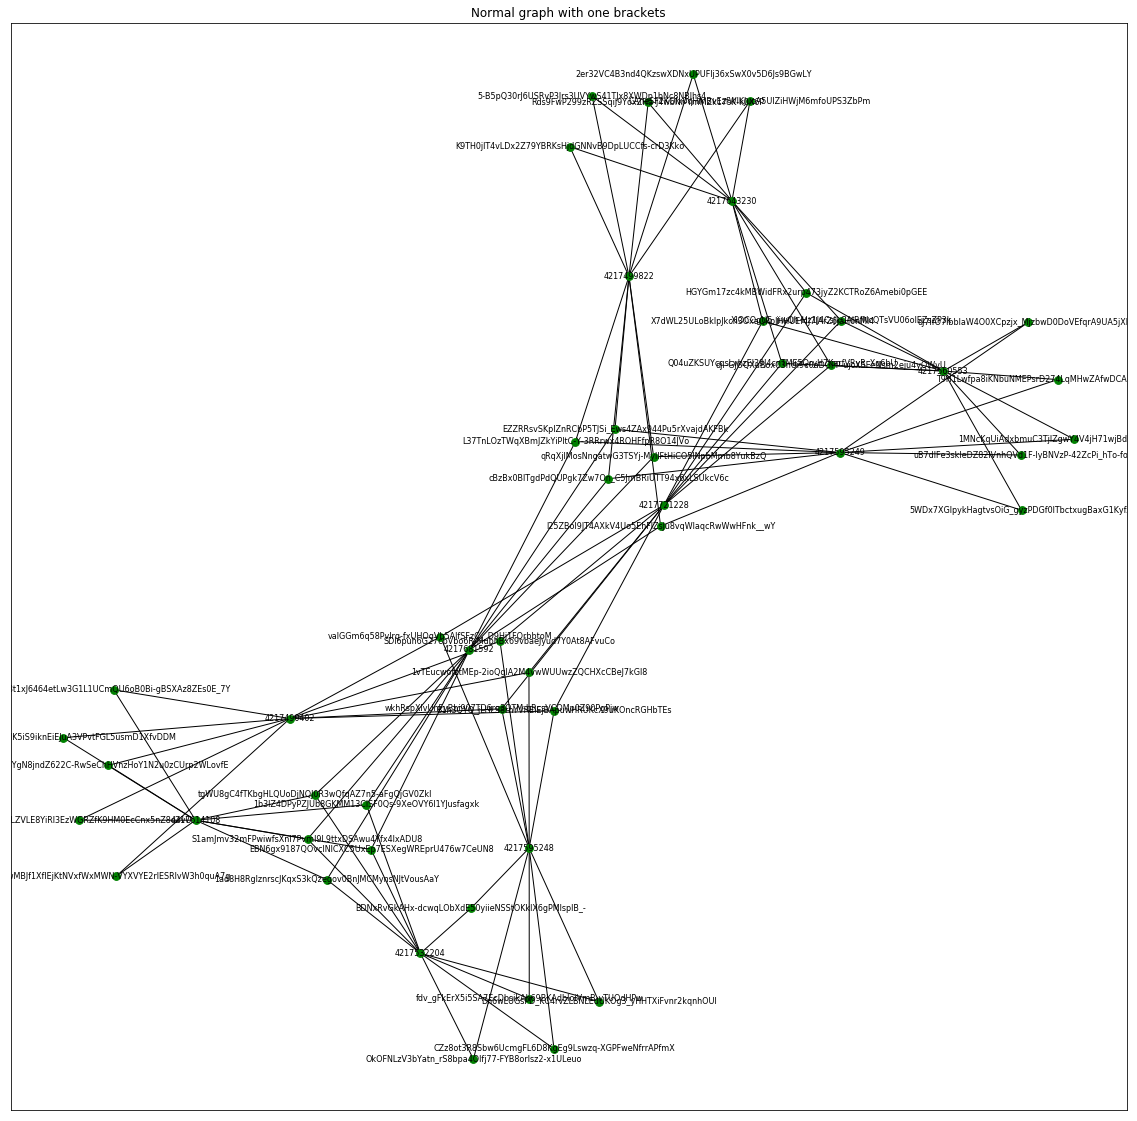

In [26]:
H = nx.Graph() 
H.add_edges_from([(i["gameId"],i["summId"]) for k,i in df_matches_saturday[df_matches_saturday["gameId"].isin(group)].iterrows()]) 

import matplotlib.pyplot as plt
plt.figure(3,figsize=(20,20)) 
nx.draw_networkx(H, with_labels = True, node_color ='green', node_size=60,font_size=8) 
plt.title("Normal graph with one brackets")
plt.show()

Change tiers to number

In [27]:
tier_to_number = {
    "CHALLENGER":9,
    "GRANDMASTER":8,
    "MASTER":7,
    "DIAMOND":6,
    "PLATINUM":5,
    "GOLD":4,
    "SILVER":3,
    "BRONZE":2,
    "IRON":1
}

Getting some extra ranks

In [28]:
import json
with open("additional_rank.json", "r") as f:
    summoner_tier = json.load(f)

In [29]:
summoner_tier = {**summoner_tier, **{i:summoner_ranks[i]["tier"] for i in summoner_ranks}}

In [30]:
match_id = groups_of_matches[0][0]
team100 = df_matches_saturday[((df_matches_saturday["gameId"] == match_id) & (df_matches_saturday["teamId"] == 100))]

In [31]:
team_tier = [summoner_tier[i] for i in team100["summId"].values]
team_tier

['PLATINUM', 'DIAMOND', 'DIAMOND', 'DIAMOND', 'GOLD']

In [32]:
team_tier_value = [tier_to_number[i] for i in team_tier]
team_tier_value

[5, 6, 6, 6, 4]

Now we can get stats on that team. Mean is used to put a rank value for the whole team. Variance is used to show rank disparity inside the team.

In [33]:
team_series = pd.Series(team_tier_value)
print(team_series.mean())
print(team_series.var())

5.4
0.8


If we compare with a another example team, it gives you the exact same mean, but with a far higher variance due to high disparity.

In [34]:
team_rank = ["DIAMOND","CHALLENGER","GRANDMASTER","BRONZE","BRONZE"]
team_value = [tier_to_number[i] for i in team_rank]
print(pd.Series(team_value).mean())
print(pd.Series(team_value).var())

5.4
10.8


Having a high disparity is not bad per se, as long as all teams in the bracket share that same disparity.

Now that we have metrics for a team, let's call them level and disparity, we have to use them to create group (or bracket) metrics. Simply getting the mean for each group metric wouldn't mean much as each group is independant. Once again, we will rely once again on variance.

In [35]:
def get_team(df_team_game):
    t = {}
    t["composition"] = set(df_team_game["summId"].values)
    t["rank_values"] = pd.Series([tier_to_number[r] for r in df_team_game["rank"].values])
    t["level"] = t["rank_values"].mean() # Rank mean
    t["disparity"] = t["rank_values"].var() # Rank variance
    t["wins"] = 1 if any(df_team_game["win"]) else 0
    return t

Improving dataframe with ranks

In [36]:
rank_list = []
errors = []
for i in df_matches_saturday["summId"]:
    rank_list.append(summoner_tier[i])
rank_series = pd.Series(rank_list)
df_matches_saturday.reset_index(inplace=True)
df_matches_saturday["rank"] = rank_series

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [37]:
get_team(df_matches_saturday[((df_matches_saturday["gameId"]==match_id) & (df_matches_saturday["teamId"]==100))])

{'composition': {'1vTEucwofztMEp-2ioQgIA2M4vwWUUwzZQCHXcCBeJ7kGl8',
  'B1h3QYQ_jLHLS8rnYVRElEjBApuwHRUKcX9uKOncRGHbTEs',
  'SDl6puh6G27cbVbo6R-MubhBx69vbaeJyud7Y0At8AFvuCo',
  'valGGm6q58PvIrq-fxUHOqVb5AlfSFzC__D9Hj1FQrbbtoM',
  'wkhRspXlvUnFyBhi907TD6rg3QTM-bRcsVCOMp0Z90PgPjw'},
 'rank_values': 0    5
 1    6
 2    6
 3    6
 4    4
 dtype: int64,
 'level': 5.4,
 'disparity': 0.8,
 'wins': 1}

In [38]:
teams = []
for matchId in groups_of_matches[0]:
    t1 = get_team(df_matches_saturday[((df_matches_saturday["gameId"]==matchId) & (df_matches_saturday["teamId"]==100))])
    t2 = get_team(df_matches_saturday[((df_matches_saturday["gameId"]==matchId) & (df_matches_saturday["teamId"]==200))])
    t1_in_teams = False
    t2_in_teams = False
    for k, t in enumerate(teams):
        if t["composition"] == t1["composition"]:
            t1_in_teams = True
            teams[k]["wins"] += t1["wins"]
        if t["composition"] == t2["composition"]:
            t2_in_teams = True
            teams[k]["wins"] += t2["wins"]
    if not t1_in_teams:
        teams.append(t1)
    if not t2_in_teams:
        teams.append(t2)

In [39]:
def get_group(teams):
    g = {}
    g["teams"] = teams
    series_mean = pd.Series([t["level"] for t in teams])
    series_variance = pd.Series([t["disparity"] for t in teams])
    g["level_variance"] = series_mean.var()
    g["disparity_variance"] = series_variance.var()
    g["level_amplitude"] = series_mean.max() - series_mean.min()
    return g

In [40]:
group_stats = get_group(teams)

In [41]:
print("level variance", group_stats["level_variance"])
print("level amplitude", group_stats["level_amplitude"])
print("disparity variance", group_stats["disparity_variance"])

level variance 0.0678571428571429
level amplitude 0.7999999999999998
disparity variance 1.2371428571428573


This way, we can see this group having a very low level variance but a medium disparity variance.

In [42]:
pd.Series([t["disparity"] for t in teams])

0    0.8
1    0.3
2    0.8
3    0.5
4    3.7
5    1.2
6    0.8
7    0.3
dtype: float64

In what is shown here, teams 4 and 5 have high disparity and are standing out from the others.

We have now metrics for a group, let's do it for all groups that have between 7 and 10 matches in it, which are the one without too much abnormalities.

In [43]:
groups_saturday = []
for group_of_matches in groups_of_matches:
    if len(group_of_matches) < 7:
        continue
    if len(group_of_matches) > 10:
        continue
    teams = []
    for matchId in group_of_matches:
        t1 = get_team(df_matches_saturday[((df_matches_saturday["gameId"]==matchId) & (df_matches_saturday["teamId"]==100))])
        t2 = get_team(df_matches_saturday[((df_matches_saturday["gameId"]==matchId) & (df_matches_saturday["teamId"]==200))])
        t1_in_teams = False
        t2_in_teams = False
        for k, t in enumerate(teams):
            if t["composition"] == t1["composition"]:
                t1_in_teams = True
                teams[k]["wins"] += t1["wins"]
            if t["composition"] == t2["composition"]:
                t2_in_teams = True
                teams[k]["wins"] += t2["wins"]
        if not t1_in_teams:
            teams.append(t1)
        if not t2_in_teams:
            teams.append(t2)
    groups_saturday.append(get_group(teams))

In this case, mean, median and variance on level variance, level amplitude and disparity variance will give us a clear overview of the situation.

In [44]:
df_groups_saturday = pd.DataFrame(groups_saturday)

Mean level variance 0.08277268259617014
Median level variance 0.07357142857142854
Variance for level variance 0.002432608198391103


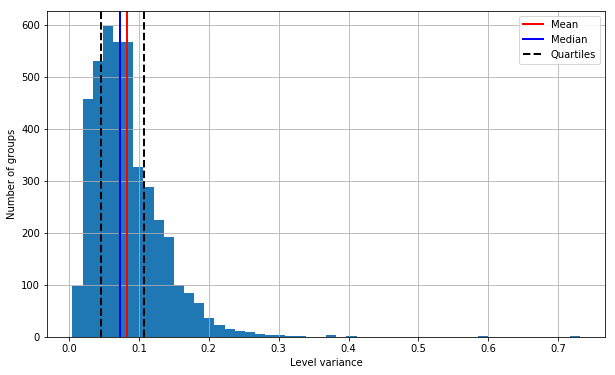

In [45]:
print("Mean level variance", df_groups_saturday["level_variance"].mean())
print("Median level variance", df_groups_saturday["level_variance"].median())
print("Variance for level variance", df_groups_saturday["level_variance"].var())
plot = (df_groups_saturday["level_variance"]).hist(bins=50, figsize=(10,6))
plot.set_xlabel("Level variance")
plot.set_ylabel("Number of groups")
plot.axvline(df_groups_saturday["level_variance"].mean(), color='red', linewidth=2)
plot.axvline(df_groups_saturday["level_variance"].median(), color='blue', linewidth=2)
plot.axvline(df_groups_saturday["level_variance"].describe()["25%"], color='k', linestyle='dashed', linewidth=2)
plot.axvline(df_groups_saturday["level_variance"].describe()["75%"], color='k', linestyle='dashed', linewidth=2)
plt.legend(["Mean","Median","Quartiles"])

The level variance seems to be very low, showing groups with team very close in term of level.

Mean level amplitude 0.7940688018979833
Median level amplitude 0.7999999999999998
Variance for level amplitude 0.0674256573439605


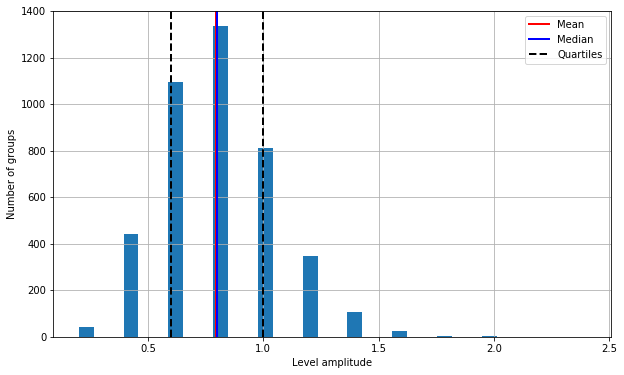

In [46]:
print("Mean level amplitude", df_groups_saturday["level_amplitude"].mean())
print("Median level amplitude",df_groups_saturday["level_amplitude"].median())
print("Variance for level amplitude",df_groups_saturday["level_amplitude"].var())
plot = df_groups_saturday["level_amplitude"].hist(bins=34, figsize=(10,6))
plot.set_xlabel("Level amplitude")
plot.set_ylabel("Number of groups")
plot.axvline(df_groups_saturday["level_amplitude"].mean(), color='red', linewidth=2)
plot.axvline(df_groups_saturday["level_amplitude"].median(), color='blue', linewidth=2)
plot.axvline(df_groups_saturday["level_amplitude"].describe()["25%"], color='k', linestyle='dashed', linewidth=2)
plot.axvline(df_groups_saturday["level_amplitude"].describe()["75%"], color='k', linestyle='dashed', linewidth=2)
plt.legend(["Mean","Median","Quartiles"])

Level amplitude shows that most of the groups have teams within a tier range (i.e. all gold, or all high gold/low platinum), but with still a significant part with higher amplitude, up to 2 tiers range (i.e. the lowest team in the group is gold, the highest diamond).

Mean disparity variance 0.31732950629836754
Median disparity variance 0.23428571428571426
Variance for disparity variance 0.09115762879045763


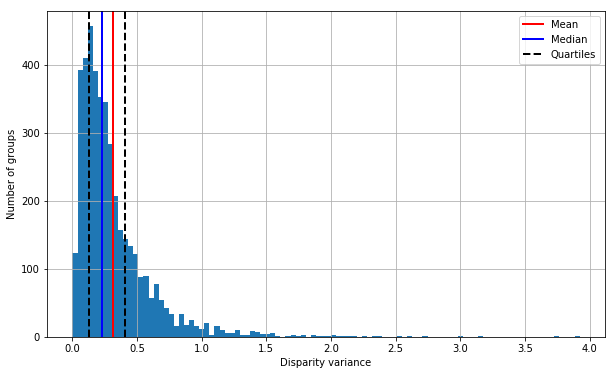

In [47]:
print("Mean disparity variance", df_groups_saturday["disparity_variance"].mean())
print("Median disparity variance",df_groups_saturday["disparity_variance"].median())
print("Variance for disparity variance",df_groups_saturday["disparity_variance"].var())
plot = df_groups_saturday["disparity_variance"].hist(bins=100, figsize=(10,6))
plot.set_xlabel("Disparity variance")
plot.set_ylabel("Number of groups")
plot.axvline(df_groups_saturday["disparity_variance"].mean(), color='red', linewidth=2)
plot.axvline(df_groups_saturday["disparity_variance"].median(), color='blue', linewidth=2)
plot.axvline(df_groups_saturday["disparity_variance"].describe()["25%"], color='k', linestyle='dashed', linewidth=2)
plot.axvline(df_groups_saturday["disparity_variance"].describe()["75%"], color='k', linestyle='dashed', linewidth=2)
plt.legend(["Mean","Median","Quartiles"])

In [48]:
df_groups_saturday["disparity_variance"].quantile(0.95)

0.8573928571428567

The disparity variance looks quite good. However it also shows that some groups have a very high disparity variance but globally speaking, it remained consistent. In more than 95% of the groups there were no team sticking out

In [49]:
with open("all_tiers.json", "w") as f:
    json.dump(summoner_tier, f)

In [50]:
len(df_match_list)

857330

In [51]:
df_match_list["summId"].unique()

array(['wJ0STN9KZhOWBnLKrnQ1SEcHnlw2xyOteCYUimiWt_QG080',
       'ioRjw2YpPrlUf9HpO0nrBrQNrWKRQfz5p9pXj2cRnKbQD68',
       '6kGe7MjDtRJ0AbyDHFlBp0MStshcVoVwWDsf0uYE6vLxOlw', ...,
       'Ro-crwlMApQ9KGtrIieuxG2BnFHmRpleKNjVAT9H16xiuwpV',
       'n-_s2nt2sX_Ue3qwrMjOuk-fivbjpU8avE_CgoigMqs0Q0Fv',
       'ogNakY-J-zPP3rFnqH6JwAkRwJsMXc1sUK8h4jlfck6Dpmsi'], dtype=object)

In [52]:
clash_players = df_match_list["summId"].unique()

In [53]:
with open("clash_players.json", "w") as f:
    json.dump(clash_players.tolist(), f)

Calculating the probability of winning (3 wins in a bracket) depending on the level and disparity of your team.

In [54]:
highest_level_wins = 0
highest_disparity_wins = 0
lowest_level_wins = 0
lowest_disparity_wins = 0

nb_teams_with_3 = 0

for g in groups_saturday:
    is_3_wins = False
    highest_level = max([t["level"] for t in g["teams"]])
    highest_disparity = max([t["disparity"] for t in g["teams"]])
    lowest_level = min([t["level"] for t in g["teams"]])
    lowest_disparity = min([t["disparity"] for t in g["teams"]])
    for t in g["teams"]:
        if t["wins"] == 3:
            nb_teams_with_3 += 1
            if highest_level == t["level"]:
                highest_level_wins += 1
            elif lowest_level == t["level"]:
                lowest_level_wins += 1
            
            if highest_disparity == t["disparity"]:
                highest_disparity_wins += 1
            if lowest_disparity == t["disparity"]:
                lowest_disparity_wins += 1

In [55]:
print("Number of teams achieving 3 wins : ", nb_teams_with_3)
print("Number of teams winning while having the lowest disparity : ", lowest_disparity_wins)
print("Number of teams winning while having the highest disparity : ", highest_disparity_wins)
print("Number of teams winning while having the lowest level : ", lowest_level_wins)
print("Number of teams winning while having the highest level : ", highest_level_wins)

Number of teams achieving 3 wins :  4038
Number of teams winning while having the lowest disparity :  900
Number of teams winning while having the highest disparity :  448
Number of teams winning while having the lowest level :  564
Number of teams winning while having the highest level :  1157


In [56]:
highest_level_wins = 0
highest_disparity_wins = 0
lowest_level_wins = 0
lowest_disparity_wins = 0

nb_teams_with_3 = 0

hhh = 0

for g in groups_saturday:
    is_3_wins = False
    highest_level = max([t["level"] for t in g["teams"]])
    highest_disparity = max([t["disparity"] for t in g["teams"]])
    lowest_level = min([t["level"] for t in g["teams"]])
    lowest_disparity = min([t["disparity"] for t in g["teams"]])
    
    if ([t["level"] for t in g["teams"]].count(highest_level) > 1 or [t["level"] for t in g["teams"]].count(lowest_level) > 1
        or [t["disparity"] for t in g["teams"]].count(highest_disparity) > 1 or [t["disparity"] for t in g["teams"]].count(lowest_disparity) > 1 ):
            continue
    for t in g["teams"]:
        if t["wins"] == 3:
            nb_teams_with_3 += 1
            if highest_level == t["level"]:
                highest_level_wins += 1
            elif lowest_level == t["level"]:
                lowest_level_wins += 1
            
            if highest_disparity == t["disparity"]:
                highest_disparity_wins += 1
                if lowest_level == t["level"]:
                    hhh +=1
            if lowest_disparity == t["disparity"]:
                lowest_disparity_wins += 1

In [57]:
print("Number of teams achieving 3 wins : ", nb_teams_with_3)
print("Number of teams winning while having the lowest disparity : ", lowest_disparity_wins)
print("Number of teams winning while having the highest disparity : ", highest_disparity_wins)
print("Number of teams winning while having the lowest level : ", lowest_level_wins)
print("Number of teams winning while having the highest level : ", highest_level_wins)

Number of teams achieving 3 wins :  942
Number of teams winning while having the lowest disparity :  160
Number of teams winning while having the highest disparity :  84
Number of teams winning while having the lowest level :  82
Number of teams winning while having the highest level :  193
